Enter the path of the dataset (CSV file):winequality-red.csv winequality-red.csv
Enter the name of the target variable:  quality


Dataset Overview:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000            

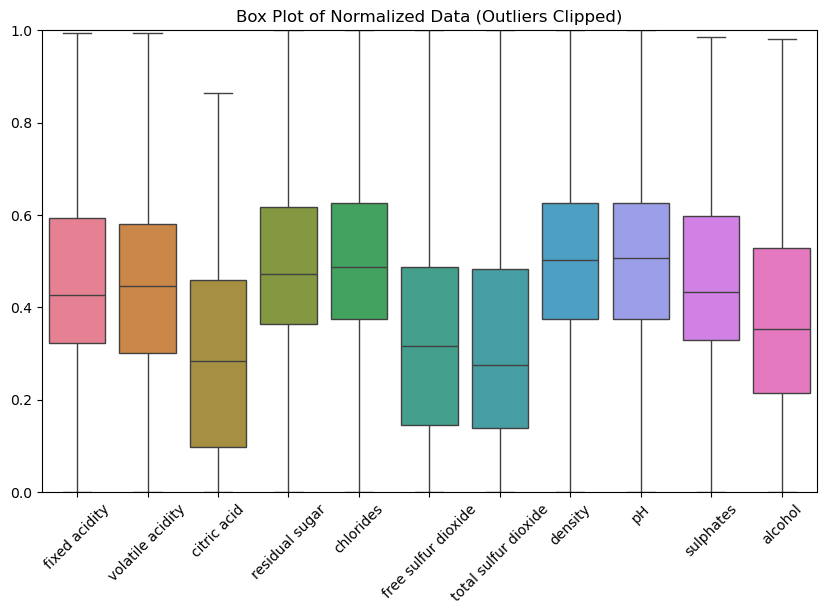


Skewness in All Numeric Features (excluding target variable):
fixed acidity           0.700371
volatile acidity        0.420909
citric acid             0.309844
residual sugar          0.856638
chlorides               0.431683
free sulfur dioxide     0.859031
total sulfur dioxide    0.972632
density                 0.025027
pH                      0.054016
sulphates               0.782826
alcohol                 0.795492
dtype: float64

Columns with Significant Skewness:
fixed acidity           0.700371
residual sugar          0.856638
free sulfur dioxide     0.859031
total sulfur dioxide    0.972632
sulphates               0.782826
alcohol                 0.795492
dtype: float64



Apply Yeo-Johnson transformation to reduce skewness? (yes/no):  yes



New skewness values (transformed columns):
fixed acidity_transformed           0.014716
residual sugar_transformed          0.020928
free sulfur dioxide_transformed     0.103396
total sulfur dioxide_transformed    0.129832
sulphates_transformed               0.024060
alcohol_transformed                 0.093370
dtype: float64


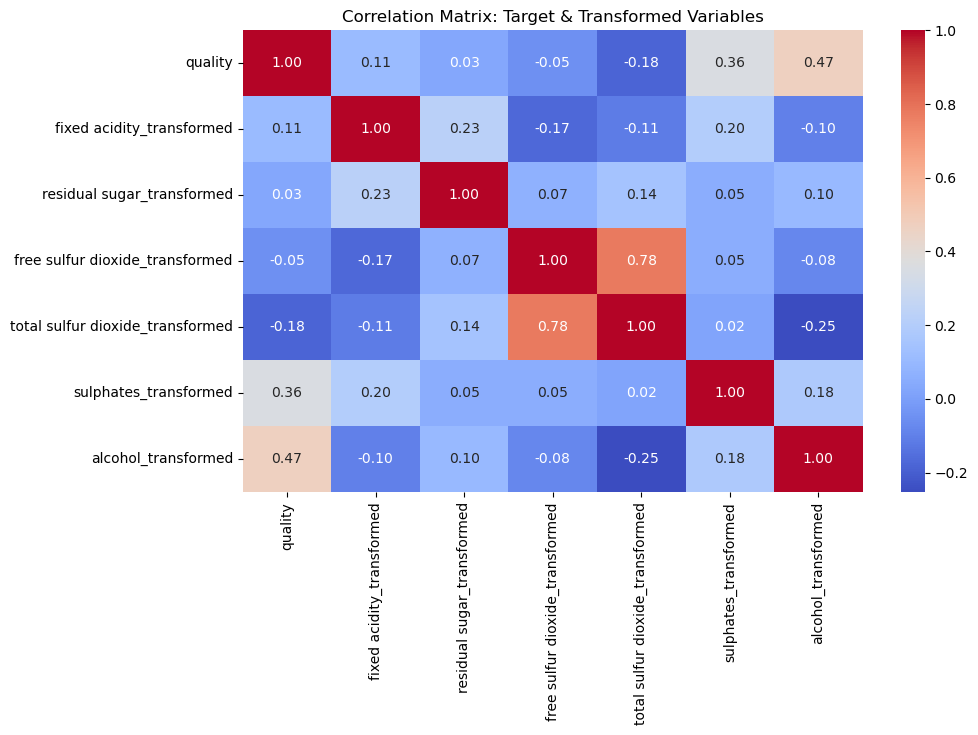


Variables with correlation higher than |0.7|:
free sulfur dioxide_transformed -- total sulfur dioxide_transformed: 0.78

Final Dataset (First 5 Rows):
   fixed acidity_original  volatile acidity  citric acid  \
0                  0.3613            0.6480       0.0000   
1                  0.4129            0.8492       0.0000   
2                  0.4129            0.7151       0.0437   
3                  0.8516            0.1788       0.6120   
4                  0.3613            0.6480       0.0000   

   residual sugar_original  chlorides  free sulfur dioxide_original  \
0                   0.3636     0.4500                        0.2439   
1                   0.6182     0.7250                        0.5854   
2                   0.5091     0.6500                        0.3415   
3                   0.3636     0.4375                        0.3902   
4                   0.3636     0.4500                        0.2439   

   total sulfur dioxide_original  density      pH  sulphates

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

def main():
    # -------------------------------------------------------------
    # 1. Load dataset
    # -------------------------------------------------------------
    file_path = input("Enter the path of the dataset (CSV file):winequality-red.csv")
    data = pd.read_csv(file_path)

    target_variable = input("Enter the name of the target variable: ")
    
    # -------------------------------------------------------------
    # 2. Describe the dataset
    # -------------------------------------------------------------
    print("Dataset Overview:")
    print(data.describe(include='all'))
    print("\nDataset Dimensions before outlier handling:", data.shape)
    print("\nData Types:")
    print(data.dtypes)

    # -------------------------------------------------------------
    # 3. Identify missing data
    # -------------------------------------------------------------
    missing_values = data.isnull().sum()
    print("\nMissing Data per Column:")
    print(missing_values[missing_values > 0])

    # -------------------------------------------------------------
    # 4. If missing data, prompt user to handle
    # -------------------------------------------------------------
    if missing_values.sum() > 0:
        print("\nWarning: There are missing values in the dataset!")
        option = input("Choose a method to handle missing values (drop/mean/median/mode/KNN): ").strip().lower()
        
        if option == "drop":
            data.dropna(inplace=True)
        
        elif option == "mean":
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                data[col].fillna(data[col].mean(), inplace=True)
            # Fill non-numeric with mode (optional)
            non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
            for col in non_numeric_cols:
                data[col].fillna(data[col].mode()[0], inplace=True)
        
        elif option == "median":
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                data[col].fillna(data[col].median(), inplace=True)
            # Fill non-numeric with mode (optional)
            non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
            for col in non_numeric_cols:
                data[col].fillna(data[col].mode()[0], inplace=True)
        
        elif option == "mode":
            # Fill all columns with mode
            for col in data.columns:
                data[col].fillna(data[col].mode()[0], inplace=True)
        
        elif option == "knn":
            # Separate numeric and non-numeric
            numeric_data = data.select_dtypes(include=[np.number])
            non_numeric_data = data.select_dtypes(exclude=[np.number])
            
            # Perform KNN on numeric only
            imputer = KNNImputer(n_neighbors=5)
            numeric_data_imputed = imputer.fit_transform(numeric_data)
            numeric_data = pd.DataFrame(numeric_data_imputed, columns=numeric_data.columns)
            
            # Fill non-numeric with mode
            for col in non_numeric_data.columns:
                non_numeric_data[col].fillna(non_numeric_data[col].mode()[0], inplace=True)
            
            # Combine back
            data = pd.concat([numeric_data, non_numeric_data], axis=1)
            data = data[data.columns]  # reorder if needed
        else:
            print("Invalid option. No imputation performed.")
    
    # -------------------------------------------------------------
    # 5. Identify and count outliers using IQR & clipping(winzorizing).
    # Instead of removing (dropping) rows, we replace any value below the lower bound with the lower bound, 
    #  and any value above the upper bound with the upper bound:preserving the dimension of the dataset
    # -------------------------------------------------------------
    def detect_outliers(df):
        outliers_count = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            if col != target_variable:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                num_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
                outliers_count[col] = num_outliers
        return outliers_count

    outliers_detected = detect_outliers(data)
    print("\nOutliers detected (before clipping):")
    for col, cnt in outliers_detected.items():
        print(f"{col}: {cnt}")

    # -------------------------------------------------------------
    # 6. Treat outliers (clip via IQR) - in place
    # -------------------------------------------------------------
    for col in data.select_dtypes(include=[np.number]).columns:
        if col != target_variable:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data[col] = np.clip(data[col], lower_bound, upper_bound)

    print("\nDataset Dimensions after outlier clipping:", data.shape)

    # -------------------------------------------------------------
    # 7. Normalize numeric columns (MinMax), excluding target
    # -------------------------------------------------------------
    scaler = MinMaxScaler(feature_range=(0, 1))
    numeric_cols = [col for col in data.select_dtypes(include=[np.number]).columns if col != target_variable]
    
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    data[numeric_cols] = data[numeric_cols].round(4)

    # (Optional) Boxplot of scaled values
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data[numeric_cols], showfliers=False)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  
    plt.title("Box Plot of Normalized Data (Outliers Clipped)")
    plt.show()

    # -------------------------------------------------------------
    # 8. Identify skewness in the numeric columns (excluding target)
    # -------------------------------------------------------------
    skew_values = data[numeric_cols].skew()
    print("\nSkewness in All Numeric Features (excluding target variable):")
    print(skew_values)

    # Filter columns with absolute skew > 0.5
    skew_data = skew_values[abs(skew_values) > 0.5]
    print("\nColumns with Significant Skewness:")
    print(skew_data)

    # -------------------------------------------------------------
    # 9. Optionally apply Yeo-Johnson transformation to skewed cols
    #    Keep both 'original' and 'transformed' in final dataset
    # -------------------------------------------------------------
    if not skew_data.empty:
        user_option = input("\nApply Yeo-Johnson transformation to reduce skewness? (yes/no): ").strip().lower()
        if user_option == "yes":
            pt = PowerTransformer(method='yeo-johnson')

            # (a) Rename each skewed column -> col + "_original"
            rename_dict = {col: col + "_original" for col in skew_data.index}
            data.rename(columns=rename_dict, inplace=True)

            # (b) Fit-transform from the newly renamed "_original" columns
            original_cols = [col + "_original" for col in skew_data.index]
            transformed_array = pt.fit_transform(data[original_cols])

            # (c) Create new columns: col + "_transformed"
            transformed_cols = [col.replace("_original", "_transformed") for col in original_cols]
            transformed_data = pd.DataFrame(transformed_array, columns=transformed_cols, index=data.index)
            transformed_data = transformed_data.round(4)

            # (d) Concatenate the new transformed columns
            data = pd.concat([data, transformed_data], axis=1)

            # Print the new skewness of the transformed columns
            print("\nNew skewness values (transformed columns):")
            print(transformed_data.skew())

    # -------------------------------------------------------------
    # 10. Correlation Matrix: ONLY target var + transformed columns
    #     (Assuming target var is numeric)
    # -------------------------------------------------------------
    transformed_cols = [c for c in data.columns if c.endswith("_transformed")]

    # If the target variable is numeric, we can do correlation
    # with the transformed columns + target variable.
    # If there are no transformed columns or the target is not numeric,
    # we handle it gracefully.
    if target_variable in data.select_dtypes(include=[np.number]).columns and len(transformed_cols) > 0:
        cols_for_corr = [target_variable] + transformed_cols
        plt.figure(figsize=(10, 6))
        corr_matrix = data[cols_for_corr].corr(numeric_only=True)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title("Correlation Matrix: Target & Transformed Variables")
        plt.show()
    
     # ------------------------ NEW CODE STARTS HERE ------------------------
        # Identify and print pairs of variables with strong correlation
        threshold = 0.7  # adjust as desired
        print(f"\nVariables with correlation higher than |{threshold}|:")
        for row_idx, row_name in enumerate(corr_matrix.index):
            for col_idx, col_name in enumerate(corr_matrix.columns):
                if col_idx > row_idx:  # to avoid duplicating pairs & skip diagonal
                    value = corr_matrix.iloc[row_idx, col_idx]
                    if abs(value) > threshold:
                        print(f"{row_name} -- {col_name}: {value:.2f}")
        # ------------------------ NEW CODE ENDS HERE --------------------------
         
    
    else:
        print("\nNo numeric target and/or no transformed columns found.")
        print("Skipping correlation matrix restricted to target + transformed variables.\n")

    # -------------------------------------------------------------
    # 11. Print the final dataset (first 5 rows) before saving
    # -------------------------------------------------------------
    print("\nFinal Dataset (First 5 Rows):")
    print(data.head())

    # -------------------------------------------------------------
    # 12. Save cleaned data to CSV
    # -------------------------------------------------------------
    
    output_path = "cleaned_dataset.csv"
    # ----------- NEW STEP: Make target variable the left-most column -----------
    all_columns = [target_variable] + [col for col in data.columns if col != target_variable]
    data = data[all_columns]
    # ---------

    data.to_csv(output_path, index=False)
    print(f"\nCleaned dataset saved as {output_path}")

if __name__ == "__main__":
    main()
